这个分析笔记由[Jake Vanderplas](http://www.vanderplas.com)编辑汇总. 源代码和license文件在[GitHub](https://github.com/jakevdp/sklearn_tutorial/)。 中文翻译由[派兰数据](http://datarx.cn)在[派兰大数据分析平台](http://palandata.com)上完成。

# 聚类：深度探索K-Means

今天我们要探索**K means**算法，这是一个无监督学习的聚类算法。

我们首先进行基本的设置：

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 介绍K-Means

K-means是一个无监督聚类的算法，也就是它根据数据本身的属性来将数据划分成不同的类别（而不是根据给定的标签）。

K-means是一个相对来说比较容易理解的算法。它每次都会根据数据的分布去寻找聚类中心。每一个点都被划分为不同的分类，每一个点与自己类别的中心在距离上都是最近的。

我们来看一看KMeans在简单的数据分布中是如何运作的。我们将用不同颜色去给不同类别的点上色。

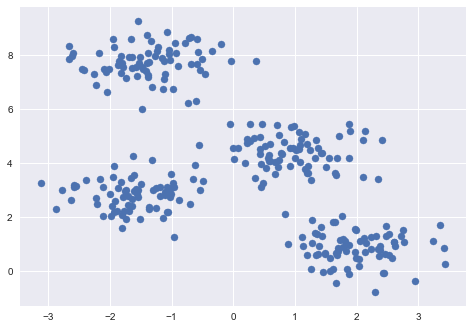

In [2]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

我们肉眼就可以看出这个数据集合的四个分类。如果您需要对这些数据做一个十分详尽的划分的话，需要的搜索空间将会是指数级别的。幸运的是，scikit-learn实现了一个众所周知的*最大期望 (Expectation Maximization)*过程，以至于上述问题可以非常快的解决。

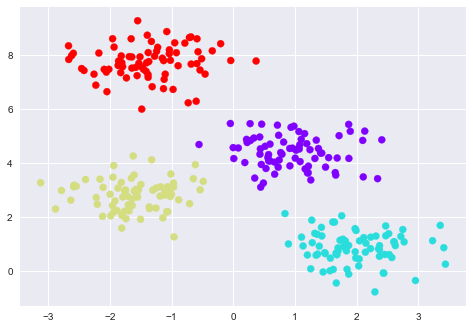

In [3]:
from sklearn.cluster import KMeans

est = KMeans(4)  # 4个聚类
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

从图中，我们可以看到这个算法划分出的数据集合和我们肉眼划分的几乎一模一样！

## K-means 算法：最大期望

K-Means 是一个灵活运用了*最大期望*的方法去获得解决方法的算法。
*最大期望*是一个由下面的两步构成的方法：

1. 猜测类别的中心  
2. 重复下面的步骤直到收敛  
      A. 将数据点归为最近的中心所对应的分类  
      B. 根据该类别的现有的数据点的分布，更新该类别中心  
    
让我们快速的看一看这个过程：

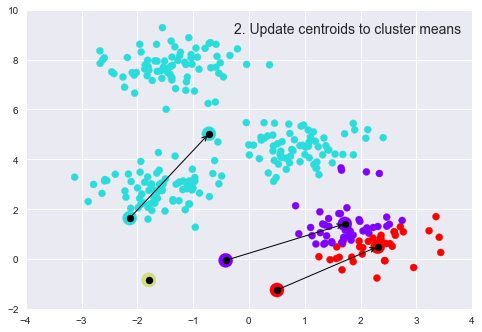

In [4]:
from fig_code import plot_kmeans_interactive

plot_kmeans_interactive();

这个算法一般来说会找到并收敛于最优的聚类中心。

### 关于KMeans的警告

KMeans并不能保证最后的结果一定是收敛的。所以，scikit-learn初始化了很多随机值，去寻找最优的结果。

同时，需要进行的分类类别个数必须事先确定。对于一些其他的聚类算法，类别的个数可以事先确定。

## KMeans 在手写数字识别上的应用

我们来看一个更贴近生活的例子，也就是我们在前几章都有提及过的手写数字的识别。在这里，我们运用Kmeans算法将64维的手写数字数据自动的分成10类，我们接下来看一看Kmeans算法有怎样的效果。

In [5]:
from sklearn.datasets import load_digits

digits = load_digits()

In [6]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

我们可以看到现在64维的数据已经被分为了10类。我们来看一看这10个中心分别代表着什么。

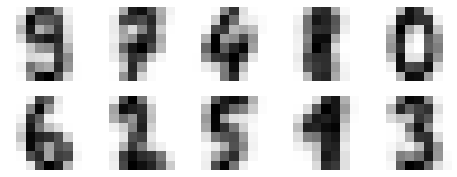

In [7]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

我们看到，即使*没有之前给定的标签*。KMeans算法也可以很好的找到数字的分类的中心。

但是数字的顺序被改变了，让我们来解决这个问题：

In [8]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

为了更好的评测结果，我们用PCA算法来看一看真实的标签和K-means算法估计的标签的异同：

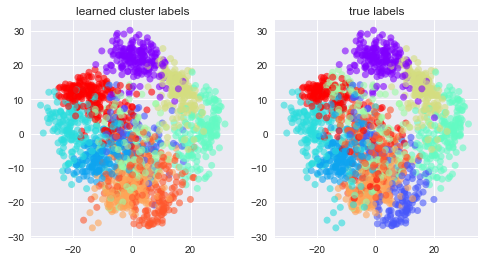

In [9]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

我们再来看一看K-means算法在**没有标签信息**的时候的分类准确率：

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(digits.target, labels)

0.79298831385642743

80%－不错！我们再来看一看预测结果的混淆矩阵：

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   1 158   0   2   0   6   7   9]
 [  0   6   0   0 163   0   0  10   2   0]
 [  0   0   0   1   1 137   1   0   0  42]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   5   0 170   2   0]
 [  0   6   3   3   0   7   2   3 101  49]
 [  0  20   0   6   0   7   0   8   0 139]]


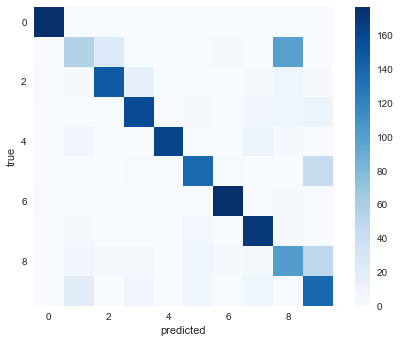

In [11]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

再一次说明，这是一个**完全的无监督的估计**，它达到了80%的正确率。

## 例子：KMeans在颜色压缩方面的应用

对于聚类而言，有一个比较有意思的应用是是颜色压缩。举个例子，假设您有一幅拥有百万种颜色的图片。在大部分的图片中，大量的颜色不会被使用，或者很大一部分的像素拥有相似或者相同的颜色。

Scikit-learn的数据库中有很多图片可以供您使用，比如：

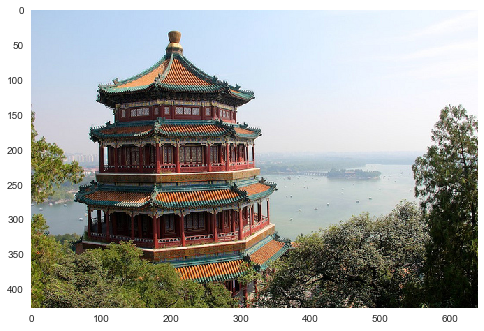

In [12]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

这个图片本身是存储在3维的矩阵中的(高度，宽度，RGB）：

In [13]:
china.shape

(427, 640, 3)

我们可以把这幅图片当作一个数据点的在3维颜色空间中的集群。我们会对调整颜色RGB数据至0-1之间，并且重新调整矩阵的结构使其成为一个典型的scikit-learn的输入：

In [14]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


我们现在有 273,280 个3维数据点。

我们的任务就是运用KMeans去压缩$256^3$种颜色，让颜色的种类总数减小（比如减到64色）。我们想在所有的数据中寻找$N_{color}$个类别中心，然后去用这64个类别中心去创建一副新的图像，在这个新的图像中，原有图像数据中的颜色会根据就近原则被最近的数据中心的颜色代替。

在这里我们使用``MiniBatchKMeans``，一个更完备，适用于更大的数据集的预测器：

In [15]:
from sklearn.cluster import MiniBatchKMeans

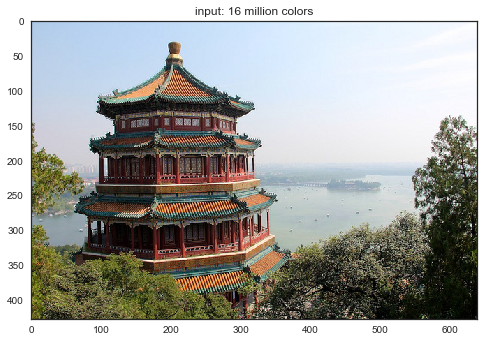

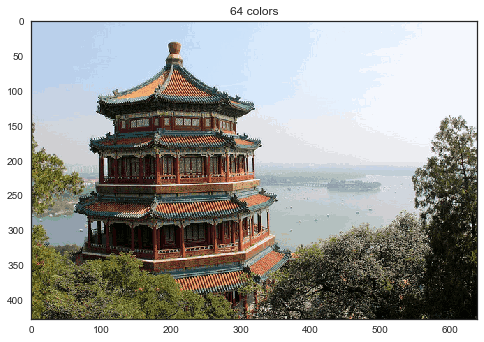

In [16]:
# reduce the size of the image for speed
n_colors = 64

X = (china / 255.0).reshape(-1, 3)
    
model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(china)
    plt.title('input: 16 million colors')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

我们可以比较输入的图片和输出的图片：我们已经将$256^3$种颜色压缩成了64种。